In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import random
import sys

src_dir = './../src/'
sys.path[0] = src_dir

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from copy import deepcopy
from scipy.stats import spearmanr


from access_biology_data import meta
from aging_tools import inout

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import chaperome, earlier_studies, companions, sequencing
from access_biology_data import annotation, relations

# Construct sanity check: get median expression for every gene

In [6]:
# Get aging expression data, filter, and map to ncbi
df_counts, df_meta, df_genes = sequencing.load_cached_aging_map(
    dataset_name='aging_map_tmm_180105',
    unambiguous_to_entrez=True,
    as_entrez=True
)

In [7]:
%%time
agg = []
for pfu in df_meta['pfu'].unique():
    f_pfu = df_meta['pfu']==pfu
    for tissue in df_meta['tissue'].unique():
        f_tissue = df_meta['tissue']==tissue
        for age in df_meta['age'].unique():
            f_age = df_meta['age']==age
            f = f_pfu & f_tissue & f_age
            
            if any(f):
                d = df_counts.loc[:, f]
                d = d.median(1).to_frame('median')
                d.loc[:, 'tissue'] = tissue
                d.loc[:, 'pfu'] = pfu
                d.loc[:, 'age'] = age
                d = d.reset_index()

                agg.append(d)
                
df_median_counts = pd.concat(agg)                

CPU times: user 2.01 s, sys: 296 ms, total: 2.3 s
Wall time: 2.43 s


In [8]:
import glob

In [9]:
p = inout.get_internal_path(
    'dynamic/tstoeger/190327_flu_inclusive_any_detected/DE/Age/*.csv')
d = glob.glob(p)

files_to_process = pd.DataFrame(columns=['path'], data = d)
files_to_process['base_name'] = files_to_process['path'].str.extract('.*/(.*).csv', expand=False)
files_to_process[['tissue', 'age', 'lower', 'higher']] = files_to_process['base_name'].str.extract(
    '^(.*)_Age_(.*)_pfu_(.*) (.*)_DE', expand=False)
files_to_process = files_to_process.set_index('base_name', verify_integrity=True)

agg = []
for j, v in files_to_process.iterrows():
    
    df = pd.read_csv(v['path'], usecols=['Symbol', 'log2FoldChange', 'pvalue', 'padj'])
    tags = ['tissue', 'age', 'lower', 'higher']
    for tag in tags:
        df.loc[:, tag] = v[tag]

    agg.append(df)

In [10]:
df = pd.concat(agg, axis=0)
df = df.rename(columns={'Symbol': 'gene_ensembl'})

for x in ['age', 'lower', 'higher']:
    df.loc[:, x] = df.loc[:, x].apply(float)

In [11]:
# Add ncbi gene IDs
df = pd.merge(
    df,
    df_genes[['gene_ensembl', 'gene_ncbi']], how='left').set_index('gene_ncbi').reset_index()

# Add some sanity checks and manually check discrepancies

In [12]:
df_median_counts['pfu'].value_counts()

0.0      2355400
150.0     612404
10.0      588850
Name: pfu, dtype: int64

In [13]:
def make_comparisons(lower_pfu, higher_pfu):
    """
    Assumes that divisor is low PFU
    
    """

    c = pd.merge(
        df_median_counts.loc[
            df_median_counts['pfu']==lower_pfu,
            ['gene_ncbi', 'median', 'age', 'tissue']],
        df_median_counts.loc[
            df_median_counts['pfu']==higher_pfu,
            ['gene_ncbi', 'median', 'age', 'tissue']],
        on = ['tissue', 'age', 'gene_ncbi'],
        suffixes=('_low', '_high'))

    c['high_over_low'] = np.log2(c['median_high'] / c['median_low'])

    c = c.dropna()

    c = c[~c['high_over_low'].isin([np.inf, -np.inf])]

    d = df[[
        'gene_ncbi', 'tissue', 'age', 'lower', 'higher', 'log2FoldChange']].groupby(
        ['gene_ncbi', 'tissue', 'age', 'lower', 'higher']).agg(np.median).reset_index()


    d = d[(d['higher']==higher_pfu) & (d['lower']==lower_pfu)]
    d = d[['gene_ncbi', 'tissue', 'age', 'log2FoldChange']]

    sup = pd.merge(c, d)
    sup['is_consistent'] = sup['high_over_low'].apply(lambda x: np.sign(x)) == sup['log2FoldChange'].apply(lambda x: np.sign(x))
    h = sup[['tissue', 'age', 'is_consistent']].groupby(['tissue', 'age']).agg(np.mean)

    plt.plot(sup['high_over_low'], sup['log2FoldChange'], '.', markersize=0.1)
    return h

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log2


is_consistent
tissue  age                
AM      4.0        0.704717
        9.0        0.717449
        12.0       0.701832
        18.0       0.714161
        24.0       0.720531
AT2     4.0        0.893694
        9.0        0.898259
        12.0       0.654904
        18.0       0.884571
        24.0       0.883265
Blood   4.0        0.723023
        9.0        0.810676
        12.0       0.793545
        18.0       0.768980
        24.0       0.846969
Lung    4.0        0.888187
        9.0        0.880649
        12.0       0.899083
        18.0       0.884969
        24.0       0.915585
MoDC    4.0        0.864653
        9.0        0.865114
        12.0       0.881479
        18.0       0.858739
        24.0       0.905804
MuscSat 24.0       0.798227

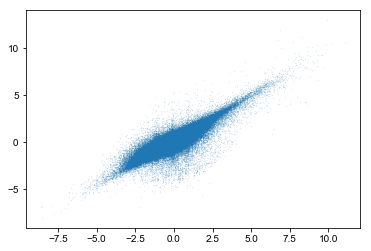

In [14]:
make_comparisons(lower_pfu=0, higher_pfu=150)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log2


is_consistent
tissue age                
AM     4.0        0.623172
       9.0        0.655973
       12.0       0.617441
       18.0       0.644845
       24.0       0.649886
AT2    4.0        0.852798
       9.0        0.847817
       12.0       0.649420
       18.0       0.830409
       24.0       0.839844
Blood  4.0        0.794634
       9.0        0.842137
       12.0       0.854329
       18.0       0.796998
       24.0       0.809802
Lung   4.0        0.815068
       9.0        0.789440
       12.0       0.881724
       18.0       0.827371
       24.0       0.899528
MoDC   4.0        0.845730
       9.0        0.897847
       12.0       0.892981
       18.0       0.849594
       24.0       0.904437

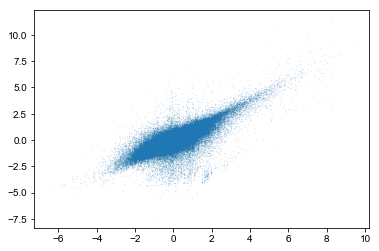

In [15]:
make_comparisons(lower_pfu=0, higher_pfu=10)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log2


is_consistent
tissue age                
AM     4.0        0.661299
       9.0        0.679311
       12.0       0.644870
       18.0       0.664522
       24.0       0.692243
AT2    4.0        0.875199
       9.0        0.864655
       12.0       0.834518
       18.0       0.865456
       24.0       0.859537
Blood  4.0        0.720017
       9.0        0.779244
       12.0       0.733973
       18.0       0.777561
       24.0       0.783317
Lung   4.0        0.814067
       9.0        0.846353
       12.0       0.871716
       18.0       0.881609
       24.0       0.887006
MoDC   4.0        0.878315
       9.0        0.802642
       12.0       0.859430
       18.0       0.874854
       24.0       0.877459

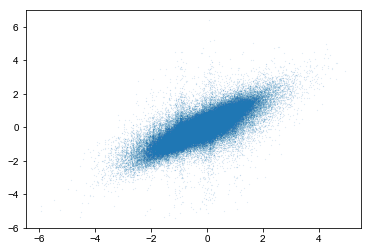

In [16]:
make_comparisons(lower_pfu=10, higher_pfu=150)

# Finally: export

In [17]:
df = df.rename(columns={'log2FoldChange': 'h_over_l'})

In [18]:
p = inout.get_internal_path('datasets/tstoeger/190327_pooled_differential_expression_flu_any_detected/age_groups.csv.gz')
inout.ensure_presence_of_directory(p)
df.to_csv(p, compression='gzip', index=False)

In [19]:
df.head()

,gene_ncbi,gene_ensembl,h_over_l,pvalue,padj,tissue,age,lower,higher
0,19039.0,ENSMUSG00000033880,3.468845,1.830568e-200,2.307980e-196,AM,9.0,0.0,150.0
1,672511.0,ENSMUSG00000070327,4.757531,3.604265e-154,2.272129e-150,AM,9.0,0.0,150.0
2,14469.0,ENSMUSG00000028270,5.373873,2.567077e-136,1.078857e-132,AM,9.0,0.0,150.0
3,15951.0,ENSMUSG00000073489,5.191991,8.101440e-110,2.553574e-106,AM,9.0,0.0,150.0
4,20847.0,ENSMUSG00000040033,3.605390,8.316424e-104,2.097070e-100,AM,9.0,0.0,150.0
